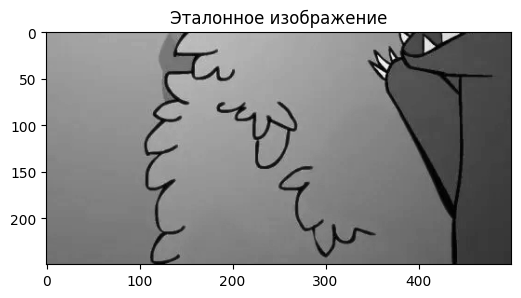

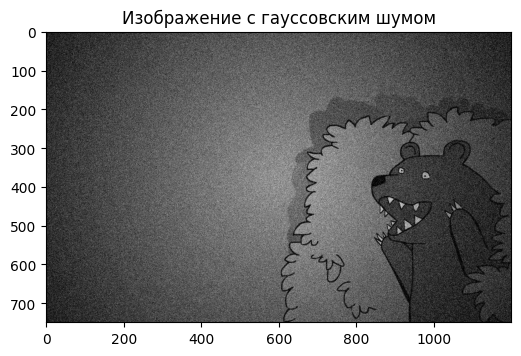

ValueError: operands could not be broadcast together with shapes (750,1200) (501,701) 

In [5]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage.util import random_noise
from mpl_toolkits.mplot3d import Axes3D

# Загрузка изображения
img = cv.imread("img.png")
img_bw = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Нормализация изображения
img_bw_normalized = img_bw / 255.0

# Определение координат и размеров шаблона
x, y, w, h = 500, 500, 500, 500
template = img_bw_normalized[y:y+h, x:x+w]

plt.figure(figsize=(6,6))
plt.title("Эталонное изображение")
plt.imshow(template, cmap='gray')
plt.show()

# Добавление гауссовского шума
noise_img = random_noise(img_bw_normalized, mode='gaussian', clip=True, mean=0, var=0.01)
noise_img_uint8 = np.array(255 * noise_img, dtype='uint8')

plt.figure(figsize=(6,6))
plt.title("Изображение с гауссовским шумом")
plt.imshow(noise_img_uint8, cmap='gray')
plt.show()

def mutual_correlation(RI, CI):
    N, M = RI.shape
    CI_height, CI_width = CI.shape
    correlation = np.zeros((CI_height - N + 1, CI_width - M + 1))
    
    # Вычисление математических ожиданий и стандартных отклонений
    M_RI = np.mean(RI)
    M_CI = cv.boxFilter(CI, ddepth=-1, ksize=(M, N))[N-1:CI_height, M-1:CI_width] / (N*M)
    
    # Центрирование изображений
    RI_centered = RI - M_RI
    CI_centered = CI - M_CI
    
    # Вычисление корреляционной функции
    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            CI_patch = CI_centered[i:i+N, j:j+M]
            correlation[i, j] = np.sum(RI_centered * CI_patch) / (N*M)
    
    # Нормирование корреляционной функции
    sigma_RI = np.std(RI)
    sigma_CI = cv.boxFilter((CI - M_CI)**2, ddepth=-1, ksize=(M, N))[N-1:CI_height, M-1:CI_width]
    sigma_CI = np.sqrt(sigma_CI / (N*M))
    correlation_normalized = correlation / (sigma_RI * sigma_CI + 1e-5)
    
    return correlation_normalized

# Вычисление взаимной корреляционной функции
correlation = mutual_correlation(template, noise_img)

plt.figure(figsize=(6,6))
plt.title("Взаимная корреляционная функция")
plt.imshow(correlation, cmap='jet')
plt.colorbar()
plt.show()

# Построение 3D графика
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(range(correlation.shape[1]), range(correlation.shape[0]))
ax.plot_surface(X, Y, correlation, cmap='viridis')
ax.set_title("3D Взаимная корреляционная функция")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Корреляция")

# Использование функции matchTemplate OpenCV
Correlation_func_cv = cv.matchTemplate(noise_img_uint8, np.uint8(template*255), cv.TM_CCORR_NORMED)
ax2 = fig.add_subplot(122, projection='3d')
X_cv, Y_cv = np.meshgrid(range(Correlation_func_cv.shape[1]), range(Correlation_func_cv.shape[0]))
ax2.plot_surface(X_cv, Y_cv, Correlation_func_cv, cmap='viridis')
ax2.set_title("3D Корреляционная функция OpenCV")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Корреляция")

plt.show()

# Нахождение координат максимума корреляционной функции
max_loc_custom = np.unravel_index(np.argmax(correlation), correlation.shape)
i_max, j_max = max_loc_custom

print(f"Координаты максимума корреляционной функции: (X: {j_max}, Y: {i_max})")
print(f"Координаты эталона: (X: {x}, Y: {y})")

# Визуализация на изображении с шумом
image_copy = noise_img_uint8.copy()
image_copy_color = cv.cvtColor(image_copy, cv.COLOR_GRAY2BGR)

# Рисование прямоугольника вокруг найденного эталона
top_left = (j_max, i_max)
bottom_right = (j_max + w, i_max + h)
cv.rectangle(image_copy_color, top_left, bottom_right, (255, 134, 0), 2)

# Рисование прямоугольника вокруг истинного эталона
cv.rectangle(image_copy_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(8,8))
plt.title("Распознавание эталона")
plt.imshow(cv.cvtColor(image_copy_color, cv.COLOR_BGR2RGB))
plt.show()

# Использование функции matchTemplate OpenCV
Correlation_func_cv = cv.matchTemplate(noise_img_uint8, np.uint8(template*255), cv.TM_CCORR_NORMED)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(Correlation_func_cv)

print(f"Координаты максимума функции matchTemplate: {max_loc}")

# Визуализация результатов
image_copy_cv = noise_img_uint8.copy()
image_copy_cv = cv.cvtColor(image_copy_cv, cv.COLOR_GRAY2BGR)

# Рисование прямоугольника вокруг найденного эталона методом OpenCV
top_left_cv = max_loc
bottom_right_cv = (top_left_cv[0] + w, top_left_cv[1] + h)
cv.rectangle(image_copy_cv, top_left_cv, bottom_right_cv, (0, 0, 255), 2)

# Рисование прямоугольника вокруг истинного эталона
cv.rectangle(image_copy_cv, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(8,8))
plt.title("Распознавание эталона методом OpenCV")
plt.imshow(cv.cvtColor(image_copy_cv, cv.COLOR_BGR2RGB))
plt.show()

# Сравнение координат
print(f"Собственная реализация: (X: {j_max}, Y: {i_max})")
print(f"OpenCV matchTemplate: {max_loc}")
print(f"Истинные координаты эталона: (X: {x}, Y: {y})")
